<a target="_blank" href="https://colab.research.google.com/github/mcks2000/llm_notebooks/blob/main/notebooks/Topic_Modeling_with_Quantized_LLMs.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **使用量化的LLM进行主题建模**
*使用BERTopic和LLM轻松创建可解释的主题*
<br>

<img src="https://pbs.twimg.com/media/GDA2JQoX0AElWoq?format=jpg&name=large">


---
        
💡 **注意事项**: 为了运行7B LLMs和BERTopic，我们建议使用GPU. 在Google Colab中，转到
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

我们将开始安装一些在本示例中将要使用的软件包：

In [1]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
!pip install bertopic datasets

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

# 📄 **数据**

我们将对一些ArXiv摘要应用主题建模。它们是主题建模的理想来源，因为它们涵盖了各种各样的主题，并且通常写作较为规范。

In [3]:
from datasets import load_dataset

# ArXiv ML Documents
docs = load_dataset("CShorten/ML-ArXiv-Papers")["train"]["abstract"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

# 🦙 **量化 LLM**

为了使用量化的LLMs，我们将使用 `GGUF` 格式以及 `llama-cpp-python`。当你访问 [TheBloke的量化模型](https://huggingface.co/TheBloke)时，你可以点击文件并找到特定的量化格式。我们将选择一个4位的量化模型：

In [4]:
!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

--2024-01-15 06:49:37--  https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 3.163.189.74, 3.163.189.114, 3.163.189.90, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/65/3b/653b1cc7a4558cd22c0ac02df471105878a080cb5694622ccd566697c574592f/cd58120326971c71c0590f6b7084a0744e287ce9c67275d8b4bf34a5947d950b?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27openhermes-2.5-mistral-7b.Q4_K_M.gguf%3B+filename%3D%22openhermes-2.5-mistral-7b.Q4_K_M.gguf%22%3B&Expires=1705560577&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNTU2MDU3N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzY1LzNiLzY1M2IxY2M3YTQ1NThjZDIyYzBhYzAyZGY0NzExMDU4NzhhMDgwY2I1Njk0NjIyY2NkNTY2Njk3YzU3NDU5Mm

接下来，我们使用 `llama-cpp-python` 加载模型：

In [5]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


我们通过自定义提示将 LLM 传递给 BERTopic。让我们添加 `KeyBERTInspired` 表示法，以便与 LLM 表示法进行比较：

In [6]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# 🗨️ **BERTopic**

通过预先计算每篇文档的嵌入，我们可以加快其他探索步骤，并在需要时利用嵌入快速迭代 BERTopic 的超参数。

🔥 **TIP**： 您可以在[MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)上找到聚类的优秀嵌入式概述。

In [7]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
# from umap import UMAP
# from hdbscan import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/3675 [00:00<?, ?it/s]

In [8]:
# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=400, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 🔥 **训练**

现在我们已经准备好了模型，可以开始训练我们的主题模型了！我们向 BERTopic 提供感兴趣的子模型，运行 `.fit_transform`，看看能得到什么样的主题。

In [9]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-01-15 07:05:12,633 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-15 07:05:20,833 - BERTopic - Dimensionality - Completed ✓
2024-01-15 07:05:20,849 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-15 07:05:34,297 - BERTopic - Cluster - Completed ✓
2024-01-15 07:05:34,336 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 39/39 [09:14<00:00, 14.21s/it]
2024-01-15 07:15:24,010 - BERTopic - Representation - Completed ✓


现在我们已经完成了模型训练，让我们看看生成了哪些主题：

In [10]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,67443,-1_the_of_and_to,"[the, of, and, to, in, we, is, for, that, on]","[models, model, datasets, networks, accuracy, ...",[Deep Learning Applied to Network Traffic Fore...,[ We investigate the complexity of logistic r...
1,0,6875,0_policy_reinforcement_learning_the,"[policy, reinforcement, learning, the, to, rl,...","[learning, reinforcement, dynamics, robot, mod...","[Reinforcement Learning, Policy Learning, Offl...","[ In reinforcement learning (RL), offline lea..."
2,1,4757,1_language_the_and_of,"[language, the, and, of, to, text, we, in, mod...","[embeddings, embedding, nlp, corpus, language,...","[Text Classification Models, , , , , , , , , ]",[ Sense representations have gone beyond word...
3,2,2896,2_speech_audio_speaker_the,"[speech, audio, speaker, the, to, and, of, in,...","[speech, trained, language, models, model, voi...","[Speech Recognition and Separation., , , , , ,...",[ Despite the close relationship between spee...
4,3,2781,3_privacy_federated_fl_data,"[privacy, federated, fl, data, the, learning, ...","[federated, distributed, datasets, algorithms,...",[Federated Learning Privacy\n\nTo generate thi...,[ Machine learning models based on sensitive ...
5,4,2088,4_graph_node_graphs_nodes,"[graph, node, graphs, nodes, the, gnns, of, ne...","[graphs, graph, networks, subgraph, embeddings...","[Graph Similarity Learning, , , , , , , , , ]",[ Many successful learning algorithms have be...
6,5,2019,5_the_of_and_to,"[the, of, and, to, in, for, equations, neural,...","[pdes, modeling, models, pde, dynamics, simula...",[- Bayesian Neural Networks\n- PDE Identificat...,[ This work presents a non-intrusive surrogat...
7,6,1849,6_adversarial_attacks_robustness_attack,"[adversarial, attacks, robustness, attack, exa...","[adversarial, adversarially, dnns, dnn, traine...",[Adversarial Attacks and Robustness in Neural ...,[ Deep Neural Networks (DNNs) have recently a...
8,7,1804,7_regret_bandit_the_algorithm,"[regret, bandit, the, algorithm, we, online, o...","[bandits, optimization, algorithms, stochastic...",[Regret Bound for Bandits Algorithms\n\nQ:\nWh...,[ The multi-armed bandit problem is a popular...
9,8,1771,8_matrix_the_rank_of,"[matrix, the, rank, of, we, is, in, and, for, ...","[matrices, factorization, matrix, sparsity, sp...","[Matrix Approximation Algorithms, , , , , , , ...","[ Recently, fundamental conditions on the sam..."


from matplotlib import pyplot as plt
_df_0['Topic'].plot(kind='hist', bins=20, title='Topic')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Count'].plot(kind='hist', bins=20, title='Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Topic', y='Count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Topic']
  ys = series['Count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Topic', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topic')
_ = plt.ylabel('Count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Topic']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Topic'}, axis=1)
              .sort_values('Topic', ascending=True))
  xs = counted['Topic']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Topic', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Topic')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['Topic'].plot(kind='line', figsize=(8, 4), title='Topic')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Count'].plot(kind='line', figsize=(8, 4), title='Count')
plt.gca().spines[['top', 'right']].set_visible(False)

# 📊 利用 DataMapPlot 实现可视化

In [11]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

我们可以使用 LLM 创建的标签，并将其分配给我们创建的主题：

In [12]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
!pip install datamapplot

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `openhermes-2.5-mistral-7b`'}>)

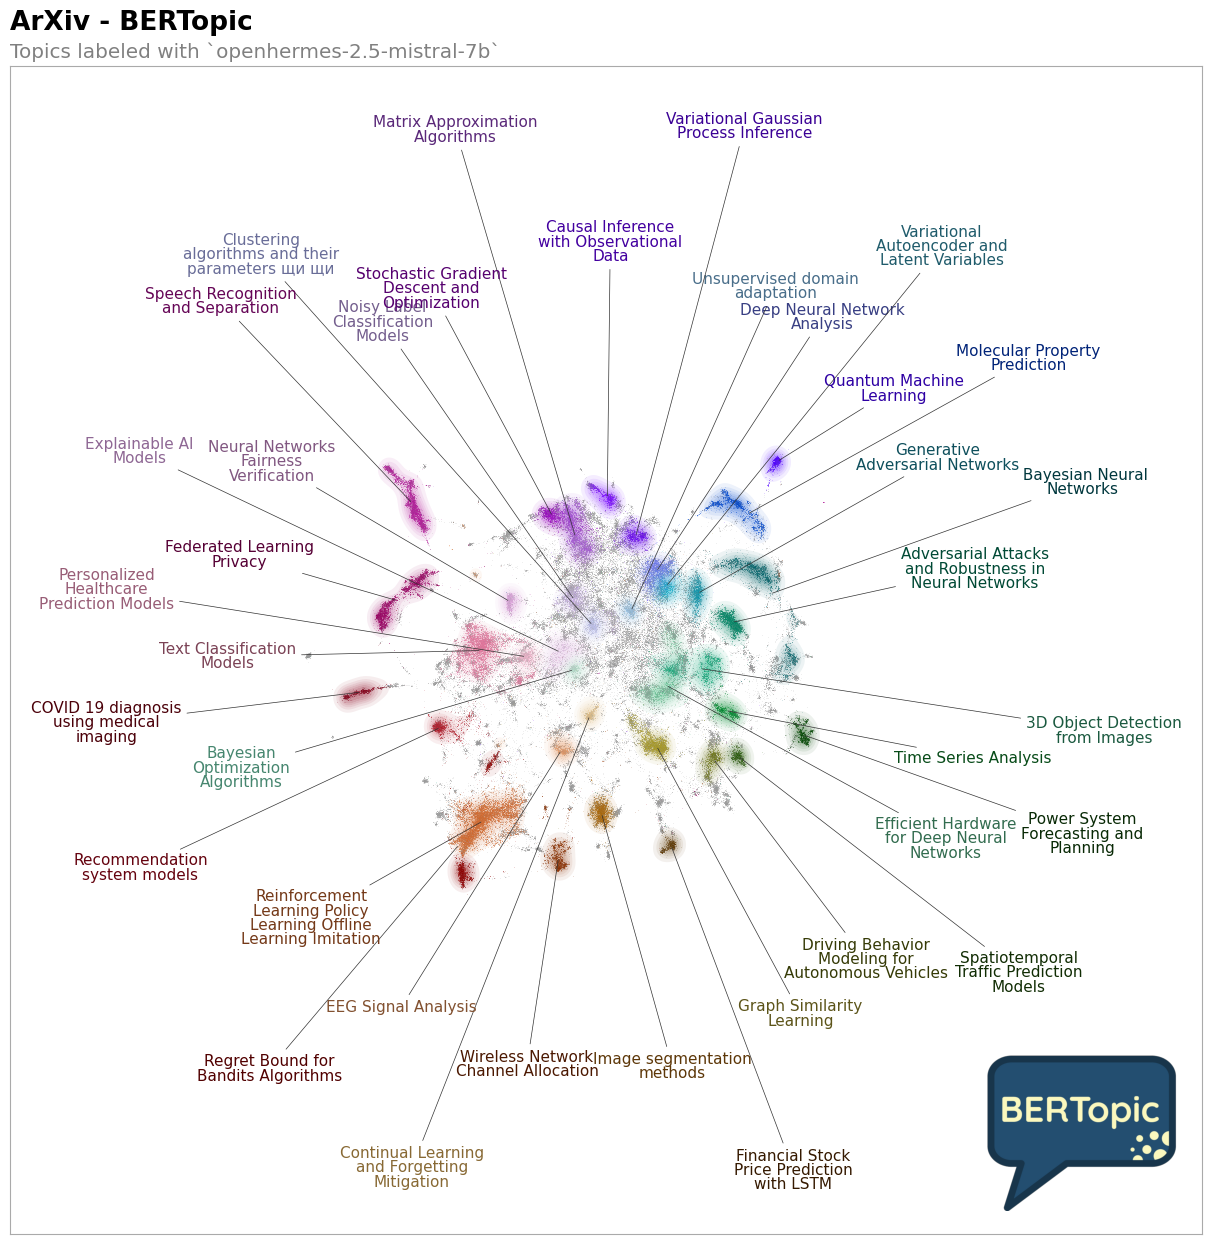

In [13]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="ArXiv - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)